<a href="https://colab.research.google.com/github/Moumeneb1/course-nlp/blob/master/Backup_Working_ULMFIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quick Start: Training an IMDb sentiment model with *ULMFiT*

Let's start with a quick end-to-end example of training a model. We'll train a sentiment classifier on a sample of the popular IMDb data, showing 4 steps:

1. Reading and viewing the IMDb data
1. Getting your data ready for modeling
1. Fine-tuning a language model
1. Building a classifier

In [1]:
from fastai.text import * 
import pandas as pd 
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Contrary to images in Computer Vision, text can't directly be transformed into numbers to be fed into a model. The first thing we need to do is to preprocess our data so that we change the raw texts to lists of words, or tokens (a step that is called tokenization) then transform these tokens into numbers (a step that is called numericalization). These numbers are then passed to embedding layers that will convert them in arrays of floats before passing them through a model.

Steps:

1. Get your data preprocessed and ready to use,
1. Create a language model with pretrained weights that you can fine-tune to your dataset,
1. Create other models such as classifiers on top of the encoder of the language model.

To show examples, we have provided a small sample of the [IMDB dataset](https://www.imdb.com/interfaces/) which contains 1,000 reviews of movies with labels (positive or negative).

In [22]:
!ls drive/My\ Drive/ULMFIT/

all_unlabeled.txt	    flaubert_fine_tuned_alldata.zip  skype_crisis.csv
Corpus_crises_diverses.zip  full_df_Features.csv	     wref30k.pth
data_clas_export.pkl	    itosref30k.pkl
data_lm_export.pkl	    models


In [25]:
path = 'drive/My Drive/ULMFIT/'
!cp drive/My\ Drive/ULMFIT/wref30k.pth ./models & cp drive/My\ Drive/ULMFIT/itosref30k.pkl ./models

In [58]:
!git clone 

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3237   NaN
3238   NaN
3239   NaN
3240   NaN
3241   NaN
Name: processed_text, Length: 3242, dtype: float64

In [56]:

df['text_clean']= df['processed_text'].map(lambda text_clean : re.sub('["#$%&()*+,-./:;<=>@[\]^_`{|}~\n\t’\']', ' ', text_clean))
df.head()

TypeError: ignored

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df['text_clean'], df['CAT3'], test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [28]:
df_trn = pd.DataFrame({'label':y_train, 'text':X_train})
df_val = pd.DataFrame({'label':y_val, 'text':X_val})

In [29]:
df_trn

,label,text
8685,Message-NonUtilisable,vient de publier une photo à grand rivière m...
6277,Message-NonUtilisable,michèle mouton françoise conconi numnumth...
8715,Message-NonUtilisable,escuse moi le gars qui vit en martinique
10084,Message-InfoUrgent,alerte cyclonique maximale liée à l ouragan ...
11766,Message-InfoUrgent,tempête un homme grièvement blessé par des dé...
...,...,...
12437,Message-NonUtilisable,sérieusement j ai pas eu une nausée aussi fort...
5264,Message-NonUtilisable,des collègues de travail qui savent affronter ...
581,Message-NonUtilisable,manuel valls débarque à lourdes aujourd hui q...
4616,Message-NonUtilisable,ça va tempête en bretagne j aimerais voir


In [30]:
tokenizer = Tokenizer(lang='fr', n_cpus=5)
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val,tokenizer=tokenizer,text_cols='text', bs=64, path = "")
# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df=df_trn,vocab=data_lm.train_ds.vocab,valid_df = df_val,tokenizer=tokenizer, label_cols='label',text_cols='text',bs=64, path = "")

In [31]:
data_lm.show_batch()

idx,text
0,de cheminée à troyes via ouestfrance … xxbos xxunk st malo sous la tempete … xxbos ouragan irma l île française de saint martin « détruite à numnum » xxbos un marseillais élu à la tête de l organisation qui rassemble les jeunes experts xxunk et xxunk aux comptes de france xxunk xxunk l avenir se prépare à marseille les xxunk xxunk xxunk paca … xxbos
1,les gens aux pays bas xxbos mdr tout le monde xxunk son grain de xxunk après l inondation on va avoir la guerre civile à xxunk xxbos inondations emmanuel macron dans l aude auprès des sinistrés xxbos inondations près de numnumnum sites à risques identifiés en algérie xxbos j ai la haine mon petit frère m appelé de guadeloupe pour me dire que la rivière a xxunk elle était
2,xxunk go train xxunk xxunk xxunk xxunk xxbos interview xxunk xxunk xxunk comme le xxunk du bien être numérique des immeubles et des entreprises xxunk … xxbos vas au bâtiment gris xxbos l équivalent d un département français est xxunk tous les sept ans dans le pays et cela concerne souvent les xxunk terres les plus xxunk les plus a xxunk inondations … xxbos lyon lyon inondation sur
3,inondation xxunk xxbos dire que hier on c est taper un xxunk sous cet tempête xxbos c est incroyable les images des inondations dans l aude là xxbos lampe tempete xxunk avec porte xxunk a l interieur numnum€ xxbos comme par hasard la tempete xxunk quand il fait jour xxbos bonne nuit nadine j espère que tu n es pas en alerte xxunk mes amis corses n ont jamais
4,pouvait envoyer des militaires et des secours avant le passage d irma ! xxbos au delà des ondes embarquez dans le xxunk club direction nume continent ! oreilles et xxunk bien ouverts corps et âme dans la danse live radio concert soirée ce samedi numnum novembre rue xxunk à marseille ! … xxbos est ce que si je xxunk xxunk un film en guadeloupe cela fait de moi un


In [32]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [33]:
data_lm.show_batch()

idx,text
0,le xxunk sollicite votre avis ! ce soir réunion sur la xxunk côtière twillingate twillingate lions club numnum h à numnum h xxbos alerte orange et fin de journée xxunk en haute corse un lotissement a été évacué à xxunk di xxunk de fortes perturbations ont été enregistrées tout au long de l après midi … pic twitter com xxunk xxbos je regarde chaque jour avec passion les
1,plus là xxrep 4 😭 xxbos s entraîner sous une tempête de pluie xxbos pauvre femme toutes mes pensées les plus sincères inondations une femme perd ses parents noyés après la mort de son mari dans l attentat de trèbes … via bfmtv xxbos et si il n y aurait pas eu ces inondations ou serait aller cet argent ? pour les migrants peut être ? xxbos des clichés
2,l anumnum au xxunk des iles en direction de lyon l autoroute est coupée en direction de lyon durée indéterminée xxbos xxunk a la suite des inondations seulement num matchs de xxunk ce week end et xxunk prend seul les commandes de l xxunk num xxunk xxbos euh la tempête elle s est installée xxunk elle xxunk qd on aura numnum ans xxbos ah ah ah avec sa colère il
3,connus des vents aussi violents pic twitter com xxunk xxbos je veux la corse cette année ! xxbos porto ve hio la chiappa numa fr numnum numnum numnumnumnum numnum numnum tempête maxi numnumnum km h du sud ouest … xxbos oups ma mère qui me demande quand c est la réunion parents profs xxbos venez on va balancer des xxunk xxunk sur irma … xxbos l alliance de
4,pirates des caraïbes ? xxbos non sérieusement là y a eu des têtes de xxunk xxunk dans l ascenseur d un bâtiment de la fac et ça inquiète personne ? la vie continue ? personne s interroge pour savoir qui sera le prochain ? xxunk moi je compte ne plus venir hein xxbos macron le terrorisme est de notre faute ! ça rappelle xxunk qui sème le vent récolte la


In [34]:
weights_pretrained = 'wref30k'
itos_pretrained = 'itosref30k'
pretained_data = (weights_pretrained, itos_pretrained)

In [35]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
learn = language_model_learner(data_lm, AWD_LSTM, config=config,
                               pretrained_fnames=pretained_data, 
                               drop_mult=0.3)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


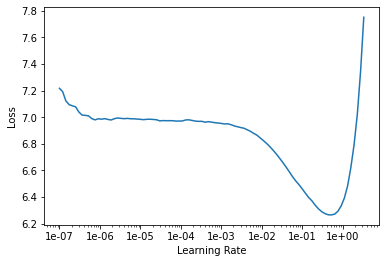

In [36]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [37]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.783680,4.801229,0.181920,00:14


In [38]:
learn.save('head_pretrained')

In [39]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.765136,4.326172,0.240179,00:17
1,4.521404,4.247757,0.253281,00:17


In [40]:
learn.save('lm_fine_tuned')

In [41]:
learn.save_encoder('ft_enc')

# Classification task
Now, we have a LM fine-tuned to our target corpus. The next step is to add layers on top of our LM to do a classification task. With fastai, it is very easy at it's done automatically

In [42]:
data_clas = TextClasDataBunch.from_df(train_df=df_trn,vocab=data_lm.train_ds.vocab,valid_df = df_val,tokenizer=tokenizer, label_cols='label',text_cols='text',bs=64, path = "")

In [43]:
config = awd_lstm_clas_config.copy()
config['n_hid'] = 1150


learn = text_classifier_learner(data_clas, AWD_LSTM, config=config,drop_mult=0.3)
learn.load_encoder('ft_enc')
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


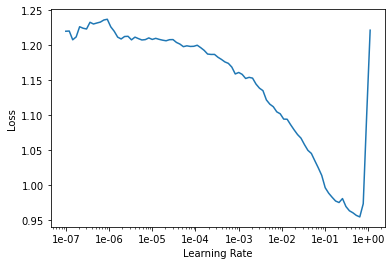

In [44]:
learn.lr_find()
learn.recorder.plot(skip_start=0)

In [45]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(7560, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(7560, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.12, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, e

In [46]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.642194,0.520262,0.797758,00:08
1,0.530241,0.487024,0.807505,00:08


In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.540038,0.481135,0.809454,00:09


In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.482388,0.457084,0.824074,00:15


In [49]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.416636,0.443234,0.832359,00:20
1,0.394777,0.449615,0.829922,00:19


In [50]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.374310,0.443055,0.835770,00:19
1,0.354411,0.454334,0.834795,00:21


In [51]:
learn.save('class-0.9349')

In [52]:
help(learn.predict)

Help on method predict in module fastai.basic_train:

predict(item:fastai.core.ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs) method of fastai.text.learner.RNNLearner instance
    Return predicted class, label and probabilities for `item`.



In [53]:
preds = []
for text in X_test:
    p = learn.predict(text)
    preds.append(str(p[0]))

In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


cr= classification_report(y_test,preds,digits=4)
print(accuracy_score(preds,y_test))
print(cr)

0.8343725643024162
                       precision    recall  f1-score   support

Message-InfoNonUrgent     0.5968    0.4440    0.5092       250
   Message-InfoUrgent     0.7924    0.6660    0.7237       470
Message-NonUtilisable     0.8650    0.9301    0.8964      1846

             accuracy                         0.8344      2566
            macro avg     0.7514    0.6800    0.7097      2566
         weighted avg     0.8256    0.8344    0.8270      2566



# After don't need it 

In [ ]:
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

In [ ]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [ ]:
bs=192

In [ ]:
data_lm.show_batch()

In [ ]:
data_lm = load_data(path, 'data_lm_export.pkl', bs=bs)
data_clas = load_data(path, 'data_clas_export.pkl', bs=bs)

Note that you can load the data with different [`DataBunch`](/basic_data.html#DataBunch) parameters (batch size, `bptt`,...)

### Fine-tuning a language model

We can use the `data_lm` object we created earlier to fine-tune a pretrained language model. [fast.ai](http://www.fast.ai/) has an English model with an AWD-LSTM architecture available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.

In [ ]:
torch.cuda.set_device(1)

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

In [ ]:
language_model_learner??

In [ ]:
learn.load_pretrained??

In [ ]:
convert_weights??

You can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to browse code. vscode things to know:

- Command palette (<kbd>Ctrl-shift-p</kbd>)
- Go to symbol (<kbd>Ctrl-t</kbd>)
- Find references (<kbd>Shift-F12</kbd>)
- Go to definition (<kbd>F12</kbd>)
- Go back (<kbd>alt-left</kbd>)
- View documentation
- Hide sidebar (<kbd>Ctrl-b</kbd>)
- Zen mode (<kbd>Ctrl-k,z</kbd>)

Like a computer vision model, we can then unfreeze the model and fine-tune it.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4,1e-2))

To evaluate your language model, you can run the [`Learner.predict`](/basic_train.html#Learner.predict) method and specify the number of words you want it to guess.

In [ ]:
learn.predict("This is a review about", n_words=10)

It doesn't make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model).

Finally we save the encoder to be able to use it for classification in the next section.

In [ ]:
learn.save('ft')
learn.save_encoder('ft_enc')

### Building a classifier

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5).to_fp16()
learn.load_encoder('ft_enc')

In [ ]:
data_clas.show_batch()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

Again, we can unfreeze the model and fine-tune it.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))

Again, we can predict on a raw text by using the [`Learner.predict`](/basic_train.html#Learner.predict) method.

In [ ]:
learn.predict("This was a great movie!")